In [2]:
from IPython.html.services.config import ConfigManager
from IPython.utils.path import locate_profile
cm = ConfigManager(profile_dir=locate_profile(get_ipython().profile))
cm.update('livereveal', {
              'theme': 'black',
              'transition': 'zoom',
              'start_slideshow_at': 'selected',
})

{u'start_slideshow_at': 'selected', u'theme': 'black', u'transition': 'zoom'}

#Lecture 8. Exterior problems and integral equations

## Outline 
- All the previous lectures you struggled with PDEs.
- PDEs are <font color='red'> local conservation laws </font>
- That lead to sparse matrices
- Integral equations represent <font color='red'> non-local equations </font> and can be <font color='red'> very efficient </font>

## PDEs are local conservation laws

PDE are local conservation laws, meaning that some quantity is "locally" conserved.

$$\frac{d}{dx} k(x) \frac{d}{dx} c(x) = f.$$

Many every-day life systems are of local structure 
(i.e. social networks, biochemical networks, graphs of all kinds)


<font color='red'> But what is a "philosophical meaning" of the integral equation? </font>

Example:  

$$\int_{\Omega} \frac{q(y)}{\Vert x - y \Vert } dy = f(x), \quad x, y \in \Omega,$$  

where $\Omega$ is some volume, or surface, or line in 3D or 2D.


## Philosophy of integral equations

The main philosophy behind non-locality of the integral equations is:

a small change in the right-hand side of 

$$
   \Delta u = f, 
$$

gives a non-local change in the solution $u$!

A short demo

We will solve (again) the Poisson equation

In [ ]:
import numpy as np
import scipy


from pyamg.gallery import poisson
n = 100
mat = poisson((n, n), 'csr')
mat = mat * (n + 1) ** 2 #To get a discretization
N = mat.shape[0]
rhs = np.ones(N)
sol = scipy.sparse.linalg.spsolve(mat, rhs)
sol = np.reshape(sol, (n, n))

And then perturb the right-hand side a little bit.

In [43]:
rhs = np.reshape(rhs, (n, n))
rhs[n/2, n/2] += 1e-3
rhs = rhs.flatten()
sol1 = scipy.sparse.linalg.spsolve(mat, rhs)
sol1 = np.reshape(sol1, (n, n))

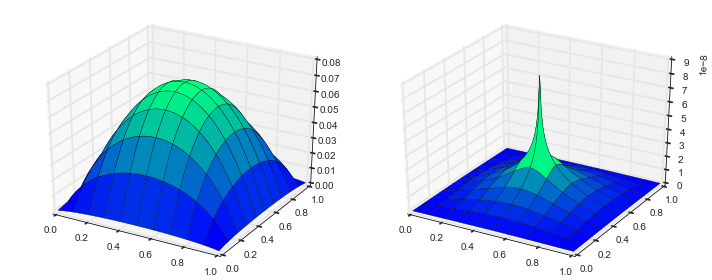

In [44]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn
from mpl_toolkits.mplot3d import Axes3D #3D plotting
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax1 = fig.add_subplot(1, 2, 2, projection='3d')
t = np.linspace(0, 1, n)
x, y = np.meshgrid(t, t)
ax.plot_surface(x, y, sol, cmap = cm.winter)
ax1.plot_surface(x, y, sol1 - sol, cmap = cm.winter)
fig.tight_layout()


## Notice
Note, that the solution **does not** decay exponentially (more like $1/r$).

## The inverse of a PDE operator
More generally, the **inverse** of the discretization of PDE operator is typically **not sparse**.


It corresponds to an **integral** operator.

A demo again, with 1D Poisson 

<matplotlib.colorbar.Colorbar instance at 0x118e3fbd8>

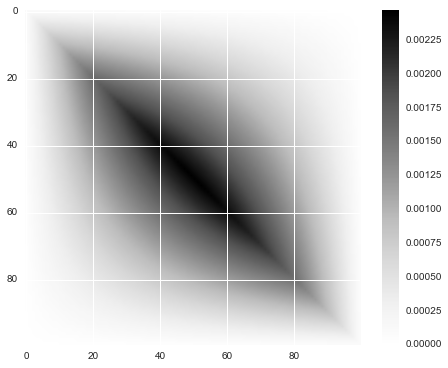

In [57]:
n = 100
mat = poisson((n, ), 'csr')
mat = mat * (n + 1) ** 2 #To get a discretization
inv_mat = np.linalg.inv(mat.todense()) #Generally, do not do that, only for demo purposes!
fig = plt.figure(figsize=(8, 6))
#ax = fig.add_subplot(1, 1, 1, projection='3d')
t = np.linspace(0, 1, n)
x, y = np.meshgrid(t, t)
#ax.contour(x, y, inv_mat, cmap = cm.winter)
plt.imshow(inv_mat)
plt.colorbar()


This is again a **slow decay**:

We need to learn about **dense matrices**, and corresponding **integral operators**

## Basic integral operator
Consider the Poisson equation with in the free-space in 3D:  


$$\Delta u = f.$$

What is the <font color='red'> solution? </font>

## The fundamental solution 
The solution to the free-space Poisson equation can be written as

$$u = \int \frac{f(y)}{\Vert x - y \Vert} dy$$

You see, that there is <font color='red'> equation here: </font>  

It is the exact solution (only have to compute 3D integral, which may be costly)

## Why it is so?

Remember school (or high school) physics, electrostatics: the point charge located at point $x$ creates  a potential in point $y$ equal to  

$$V(x, y) = \frac{1}{r}, \quad r = \Vert x - y \Vert.$$

And what is the "point charge"? 

If we take the Laplacian of $V(x, y)$ at point $y$ we get

$$ \Delta V(x, y) = \delta(x - y), $$

where $\delta(x)$ is the 3D <font color='red'> delta function </font>

## What is a delta function?
<font=7.0>  


1. Physisist: it is a function that $\delta(0) = \infty, \delta(x) = 0, \quad x \ne 0$ and  
 $$\int_{-\infty}^{\infty} \delta(x) dx = 1$$
 
2. Physisist, version 2. It is a function such that $$\int_{-\infty}^{\infty} \delta(x) f(x) dx = 0$$ for any $f$

3. Mathematician: it is a generalized function, i.e. a <font color='red'> linear functional </font> on a space of "good" functions (analytic functions with bounded support).  
The functional is simple: 
$$\langle \delta, f \rangle = f(0).$$ </font>

## Discrete $\delta$-function
On a discrete level, it is simple: just put the column of identity matrix into the right-hand side,  and that is a $\delta$-function. But, have to scale it (<font color='red'> why? </font>).

## Back to the integral equation
Consider again the fundamental solution:

$$K(x, y) = \frac{1}{\Vert x - y \Vert}$$

This function satisfies

$$
   \Delta_x K(x, y) = 0, 
$$
for all $y \ne x$. 

$K(x, y)$ it is a solution of the Poisson equation with zero right-hand side everywhere, except one point!  


<font color='red'> Where it can be helpful? </font>  



In the solution of <font color='red'> exterior problems! </font>

## Exterior and interior problems
What we have considered before, were <font color='red'> interior problems </font>, i.e. the solution is sought in the <font color = 'red'> bounded domain </font>

- **Interior problems**: diffusion, elasticity, fluid flows in a cavity
- **Extrerior problems**: scattering (acoustics, electromagnetics, electrostatics), where the solution is not periodic/decays slowly in the infinity (remember point charge!)

## Why integral equations in the the exterior problems?

Consider a bounded domain (i.e., a cube) attached to a battery. That means, the potential is constant on the surface of the cube.

There are no charges in the space, thus we have the **exterior Dirichlet problem**:

$$\Delta V = 0, \quad V(x) = 1, \quad x \in \partial \Omega$$


Remember our formula:
    
$$u(x) = \int \frac{f(y)}{\Vert x - y \Vert } dy.$$  

Can it help?

Yes, it can: consider the integration over the **surface of the cube**,  


$$V(x) = \int_{\partial \Omega} \frac{q(y)}{\Vert x - y \Vert} dy.$$  

It satisfies $$\Delta_x V(x) = 0$$ for all $x \notin \partial \Omega$ for **any** $q(y)$.

But it does not satisfy the **boundary condition** !

## Integral equation

Let us make it the equation!

$$\int_{\partial \Omega} \frac{q(y)}{\Vert x - y \Vert} dy = g(x) = 1, \quad x \in \partial \Omega$$

This the <font color='red'> equation for the unknown function </font> $q(y)$ that is defined on the surface!  

And it has very simple meaning -- a battery generates the charges on the surface

##Engineers love integral equations

Why IE are good?

- Bounded domain discretization
- No need to bother with boundary conditions (boundary conditions are the equations, in fact)
- Simple elements (piecewise-constant, piecewise linear) can be used to get a qualitative picture
- Ok for Maxwell equations, acoustics, electrostatics, elasticity problems

## Applications of IE
- Mechanical engineering (bridges, elasticity)
- Antennas and propagation (radars, communication systems)
- Acoustics (sonars, noise cancellation and modelling)
- MRI (high-resolution tomography)

## What are the problems of IE

Integral equations have several problems

- They yield dense matrices that can be large and/or ill-conditioned
- Computation of the matrix elements require the computation of singular integrals
- Not every problem is easy to reformulate as an integral equation, i.e. it requires "homogenious media"   where you can **invert** the differential operator 

  <font color='red'> Example: a multilayer medium, or antenna system requires a special treatment </font>

## Problem 1: Dense matrices
For a surface integral equation, $N = \mathcal{O}(n^2)$, 

- Memory: if all the matrix elements are computed, this gives $10^4 \times 10^4$ (at least) matrices, and   we run out of memory.  
- Complexity: if nothing special is done, $\mathcal{O}(N^3)$ complexity.

If we have a non-homogenious scatterer, we get **volume integral equations**

<font color='red'> Solution: use data-sparse approximation of the matrix </font>

## Problem 2: Discretization and elements

There are several methods to discretize an integral equation (we will discuss them in the next lecture).  

They lead to the integrals of the form

$$
   \int_{\Pi} \frac{1}{r} dy
$$

where the integral is over an **elementary cell**. This is called **singular integrals**.

There also can be integrals of the form

$$
   \int_{\Pi} \frac{1}{r^2} dy, 
$$

and 
$$
   \int_{\Pi} \frac{1}{r^3} dy
$$
(?!)
<font color='red'> Hint: </font> try to compute the integral $\int_{-1}^{1} \frac{1}{x^2} dx$.

## Problem 2: Discretization and elements (cont)
This is solved by **special quadratures** and is mainly an art (i.e. subtract a singularity, integrate it analytically, etc.)

## Problem 3: Applicability
The application of classical IE is limited to the **linear problems** (forget about Navier-Stokes for a moment) and with **homogenious media**: we have to write down the analytic solution.  

However, a recent research (which we are doing as well) shows that **fundamental solutions** can be computed on the discrete level, once we have the discretization of the system (i.e. sparse matrices)

## BEM++ software package
There are  quite a few closed-source solutions for solving integral equations in specific application areas.  

The BEM++ package http://www.bempp.org/ is one of the few exceptions.

## Conclusions
Integral equations are extremely efficient if applied in the right context

They can solve exterior/interior problems for:

- Laplace equation
- Helmholtz equation
- Maxwell equations

The ideas can also be applied to provide efficient sparse matrix solvers.

In [58]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()